### Motion retargeting of `CMU-MoCap` to `G1`

In [1]:
import sys,mujoco
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
sys.path.append('../package/helper/')
sys.path.append('../package/mujoco_usage/')
sys.path.append('../package/bvh_parser/')
sys.path.append('../package/motion_retarget/')
from mujoco_parser import *
from slider import *
from utility import *
from transformation import *
from bvh_parser import *
from joi import *
from mr_cmu import *
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

Ready.


#### Parse `Unitree G1`

In [2]:
xml_path = '../asset/unitree_g1/scene_g1.xml'
env = MuJoCoParserClass(name='',rel_xml_path=xml_path,verbose=True)

name:[] dt:[0.002] HZ:[500]
n_qpos:[44] n_qvel:[43] n_qacc:[43] n_ctrl:[37]

n_body:[39]
 [0/39] [world] mass:[0.00]kg
 [1/39] [pelvis] mass:[2.86]kg
 [2/39] [left_hip_pitch_link] mass:[1.30]kg
 [3/39] [left_hip_roll_link] mass:[1.45]kg
 [4/39] [left_hip_yaw_link] mass:[2.05]kg
 [5/39] [left_knee_link] mass:[2.25]kg
 [6/39] [left_ankle_pitch_link] mass:[0.07]kg
 [7/39] [left_ankle_roll_link] mass:[0.39]kg
 [8/39] [right_hip_pitch_link] mass:[1.30]kg
 [9/39] [right_hip_roll_link] mass:[1.45]kg
 [10/39] [right_hip_yaw_link] mass:[2.05]kg
 [11/39] [right_knee_link] mass:[2.25]kg
 [12/39] [right_ankle_pitch_link] mass:[0.07]kg
 [13/39] [right_ankle_roll_link] mass:[0.39]kg
 [14/39] [torso_link] mass:[7.52]kg
 [15/39] [left_shoulder_pitch_link] mass:[0.71]kg
 [16/39] [left_shoulder_roll_link] mass:[0.64]kg
 [17/39] [left_shoulder_yaw_link] mass:[0.71]kg
 [18/39] [left_elbow_pitch_link] mass:[0.60]kg
 [19/39] [left_elbow_roll_link] mass:[0.51]kg
 [20/39] [left_zero_link] mass:[0.05]kg
 [21/3

#### Load `CMU-MoCap`

In [3]:
# Load CMU-MoCap
bvh_path = "../bvh/cmu_mocap/07_01.bvh"
secs,chains = get_chains_from_bvh_cmu_mocap(
    bvh_path         = bvh_path,
    p_rate           = 0.056444*1.0, # 1.0
    zup              = True,
    plot_chain_graph = False,
    verbose          = False,
)
secs,chains = secs[1:],chains[1:] # exlude the first frame (T-pose)
L = len(chains)
dt = secs[1]-secs[0]
HZ = int(1/dt)
print ("[%s] loaded. L:[%d] dt:[%.4f]sec HZ:[%d]"%(bvh_path,L,dt,HZ))

[../bvh/cmu_mocap/07_01.bvh] loaded. L:[316] dt:[0.0083]sec HZ:[120]


#### Animate motion

In [4]:
env.reset(step=True)
env.init_viewer(transparent=True)
tick = 0
while env.is_viewer_alive():
    chain = chains[tick]
    env.plot_T()
    chain.plot_chain_mujoco(env=env,plot_joint_name=False)
    env.render()
    if tick < (L-1): tick = tick + 1
print ("Done.")

Done.


#### Estimate the foot contact of motion

min_seg_sec:[0.10]sec min_seg_len:[12]
We have [3] right contact segment(s)
 [0] len:[45]
 [1] len:[51]
 [2] len:[51]
We have [2] left contact segment(s)
 [0] len:[41]
 [1] len:[42]


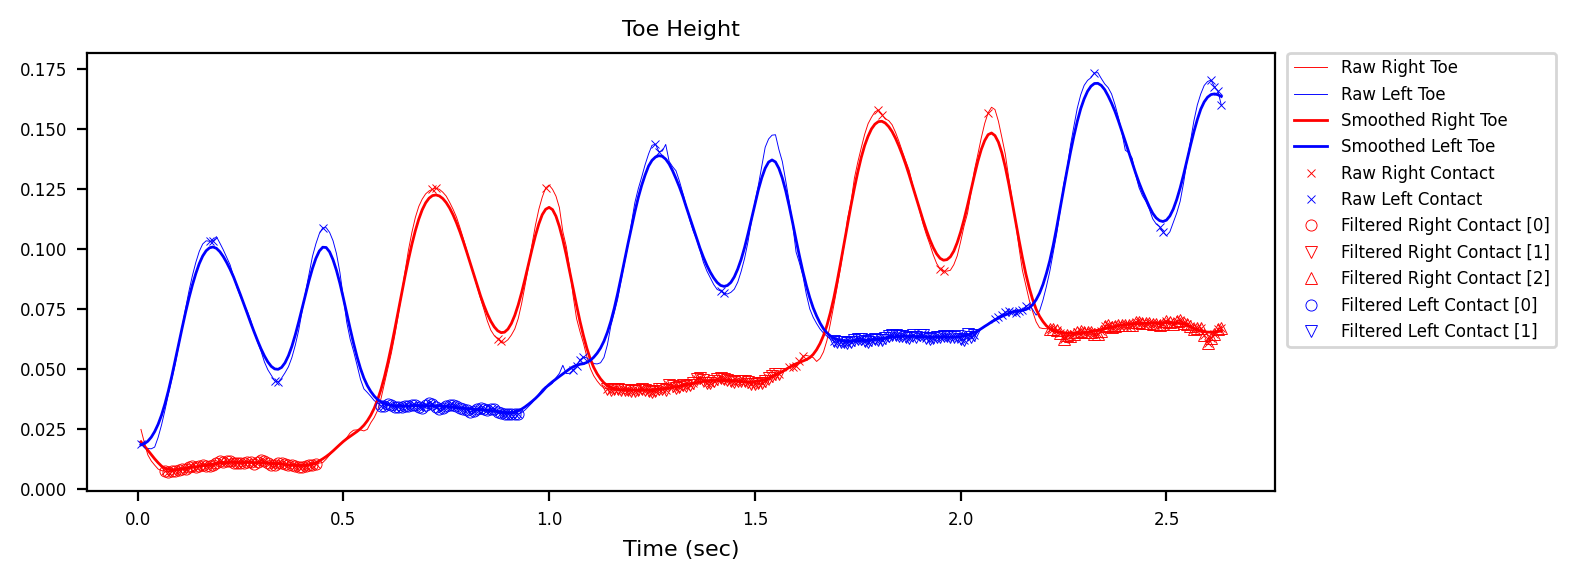

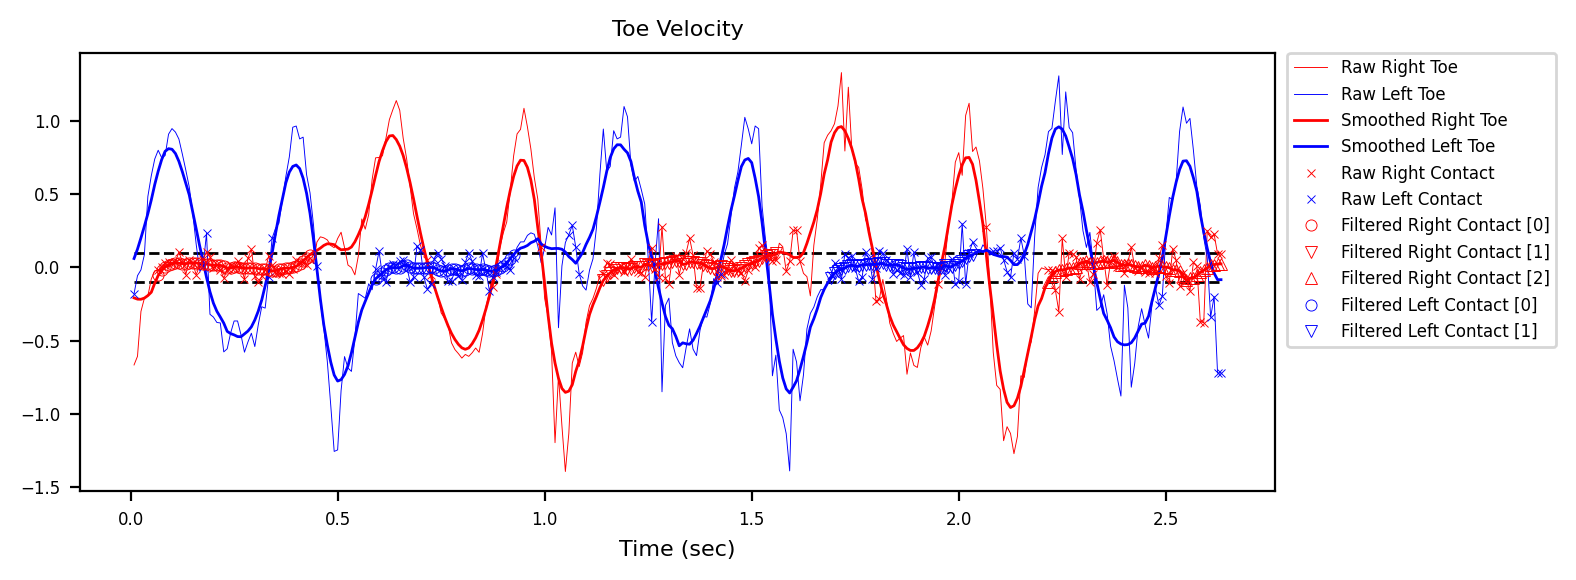

Right Contact [0/3] [7]~[51]
Right Contact [1/3] [136]~[186]
Right Contact [2/3] [265]~[315]
Left Contact [0/2] [70]~[110]
Left Contact [1/2] [202]~[243]
Done.


In [5]:
# Toe and ankle trajectories
rtoe_traj,ltoe_traj = np.zeros((L,3)),np.zeros((L,3))
ra_traj,la_traj = np.zeros((L,3)),np.zeros((L,3))
for tick in range(L):
    chain = chains[tick]
    T_joi = get_T_joi_from_chain_cmu(chain)
    rtoe_traj[tick,:],ltoe_traj[tick,:] = t2p(T_joi['rtoe']),t2p(T_joi['ltoe'])
    ra_traj[tick,:],la_traj[tick,:] = t2p(T_joi['ra']),t2p(T_joi['la'])
# Get contact segments
rcontact_segs,lcontact_segs = get_contact_segments(
    secs,
    rtoe_traj,
    ltoe_traj,
    zvel_th     = 0.1, # toe z velocity threshold to detect contact
    min_seg_sec = 0.1, # minimum segment time (to filter out false-positve contact segments)
    smt_sigma   = 5.0, # Gaussian smoothing sigma
    smt_radius  = 5.0, # Gaussian smoothing radius (filter size)
    verbose     = True,
    plot        = True,
)
rcontact_segs_concat = np.concatenate(rcontact_segs) # [M]
lcontact_segs_concat = np.concatenate(lcontact_segs) # [M]
for c_idx,rcontact_seg in enumerate(rcontact_segs):
    print ("Right Contact [%d/%d] [%d]~[%d]"%
           (c_idx,len(rcontact_segs),rcontact_seg[0],rcontact_seg[-1]))
for c_idx,lcontact_seg in enumerate(lcontact_segs):
    print ("Left Contact [%d/%d] [%d]~[%d]"%
           (c_idx,len(lcontact_segs),lcontact_seg[0],lcontact_seg[-1]))    
print ("Done.")

#### Motion retargeting: unit-vector method

In [6]:
env.reset(step=True)
env.init_viewer(
    title='Motion Retargeting using Unit Vector Method',
    transparent=True)
tick,render_every = 0,10
qpos_list,R_ra_list,R_la_list = [],[],[]
while env.is_viewer_alive() and (tick<L):
    # Get chain source
    chain = chains[tick]
    T_joi_src = get_T_joi_from_chain_cmu(chain,hip_between_pelvis=True)

    # Contact label
    rcontact = tick in rcontact_segs_concat
    lcontact = tick in lcontact_segs_concat

    # Move target base
    if tick == 0: # move base once
        T_base_src  = T_joi_src['hip']
        T_base_trgt = T_yuzf2zuxf(T_base_src)
        env.set_T_base_body(body_name='pelvis',T=T_base_trgt)
        env.forward()

    # Start motion retargeting
    T_joi_trgt = get_T_joi_from_g1(env)

    # Get body link lengths of the target rig
    len_hip2neck   = len_T_joi(T_joi_trgt,'hip','neck')
    len_neck2rs    = len_T_joi(T_joi_trgt,'neck','rs')
    len_rs2re      = len_T_joi(T_joi_trgt,'rs','re')
    len_re2rw      = len_T_joi(T_joi_trgt,'re','rw')
    len_neck2ls    = len_T_joi(T_joi_trgt,'neck','ls')
    len_ls2le      = len_T_joi(T_joi_trgt,'ls','le')
    len_le2lw      = len_T_joi(T_joi_trgt,'le','lw')
    len_hip2rp     = len_T_joi(T_joi_trgt,'hip','rp')
    len_rp2rk      = len_T_joi(T_joi_trgt,'rp','rk')
    len_rk2ra      = len_T_joi(T_joi_trgt,'rk','ra')
    len_hip2lp     = len_T_joi(T_joi_trgt,'hip','lp')
    len_lp2lk      = len_T_joi(T_joi_trgt,'lp','lk')
    len_lk2la      = len_T_joi(T_joi_trgt,'lk','la')
    
    # IK configuration for the full body
    rev_joint_names_for_ik_full_body = env.rev_joint_names
    joint_idxs_jac_full_body = env.get_idxs_jac(
        joint_names=rev_joint_names_for_ik_full_body)
    joint_idxs_jac_full_body_with_base = np.concatenate(
        ([0,1,2,3,4,5],joint_idxs_jac_full_body)) # add base free joints

    # Get unit vectors of the source rig
    uv_hip2neck   = uv_T_joi(T_joi_src,'hip','neck')
    uv_neck2rs    = uv_T_joi(T_joi_src,'neck','rs')
    uv_rs2re      = uv_T_joi(T_joi_src,'rs','re')
    uv_re2rw      = uv_T_joi(T_joi_src,'re','rw')
    uv_neck2ls    = uv_T_joi(T_joi_src,'neck','ls')
    uv_ls2le      = uv_T_joi(T_joi_src,'ls','le')
    uv_le2lw      = uv_T_joi(T_joi_src,'le','lw')
    uv_hip2rp     = uv_T_joi(T_joi_src,'hip','rp')
    uv_rp2rk      = uv_T_joi(T_joi_src,'rp','rk')
    uv_rk2ra      = uv_T_joi(T_joi_src,'rk','ra')
    uv_hip2lp     = uv_T_joi(T_joi_src,'hip','lp')
    uv_lp2lk      = uv_T_joi(T_joi_src,'lp','lk')
    uv_lk2la      = uv_T_joi(T_joi_src,'lk','la')
    
    # Set positional targets
    p_hip_trgt   = t2p(T_joi_src['hip'])
    p_neck_trgt  = p_hip_trgt + len_hip2neck*uv_hip2neck
    p_rs_trgt    = p_neck_trgt + len_neck2rs*uv_neck2rs
    p_re_trgt    = p_rs_trgt + len_rs2re*uv_rs2re
    p_rw_trgt    = p_re_trgt + len_re2rw*uv_re2rw
    p_ls_trgt    = p_neck_trgt + len_neck2ls*uv_neck2ls
    p_le_trgt    = p_ls_trgt + len_ls2le*uv_ls2le
    p_lw_trgt    = p_le_trgt + len_le2lw*uv_le2lw
    p_rp_trgt    = p_hip_trgt + len_hip2rp*uv_hip2rp
    p_rk_trgt    = p_rp_trgt + len_rp2rk*uv_rp2rk
    p_ra_trgt    = p_rk_trgt + len_rk2ra*uv_rk2ra
    p_lp_trgt    = p_hip_trgt + len_hip2lp*uv_hip2lp
    p_lk_trgt    = p_lp_trgt + len_lp2lk*uv_lp2lk
    p_la_trgt    = p_lk_trgt + len_lk2la*uv_lk2la

    # Set IK targets
    joi_body_name = get_joi_body_name_of_g1()
    ik_info_full_body = init_ik_info()
    add_ik_info(ik_info_full_body,body_name=joi_body_name['rs'],p_trgt=p_rs_trgt)
    add_ik_info(ik_info_full_body,body_name=joi_body_name['re'],p_trgt=p_re_trgt)
    add_ik_info(ik_info_full_body,body_name=joi_body_name['rw'],p_trgt=p_rw_trgt)
    add_ik_info(ik_info_full_body,body_name=joi_body_name['ls'],p_trgt=p_ls_trgt)
    add_ik_info(ik_info_full_body,body_name=joi_body_name['le'],p_trgt=p_le_trgt)
    add_ik_info(ik_info_full_body,body_name=joi_body_name['lw'],p_trgt=p_lw_trgt)
    add_ik_info(ik_info_full_body,body_name=joi_body_name['rp'],p_trgt=p_rp_trgt)
    add_ik_info(ik_info_full_body,body_name=joi_body_name['rk'],p_trgt=p_rk_trgt)
    add_ik_info(ik_info_full_body,body_name=joi_body_name['ra'],p_trgt=p_ra_trgt)
    add_ik_info(ik_info_full_body,body_name=joi_body_name['lp'],p_trgt=p_lp_trgt)
    add_ik_info(ik_info_full_body,body_name=joi_body_name['lk'],p_trgt=p_lk_trgt)
    add_ik_info(ik_info_full_body,body_name=joi_body_name['la'],p_trgt=p_la_trgt)

    # Solve IK
    max_ik_tick = 100
    for ik_tick in range(max_ik_tick): # ik loop
        dq,ik_err_stack = get_dq_from_ik_info(
            env            = env,
            ik_info        = ik_info_full_body,
            stepsize       = 1,
            eps            = 1e-2,
            th             = np.radians(10.0),
            joint_idxs_jac = joint_idxs_jac_full_body_with_base,
        ) # dq:[43]
        qpos = env.get_qpos() # get current joint position  [44]
        mujoco.mj_integratePos(env.model,qpos,dq,1)
        env.forward(q=qpos)
        if np.linalg.norm(ik_err_stack) < 0.05: break
            
    # Render
    T_joi_trgt = get_T_joi_from_g1(env)
    if (tick)%render_every == 0:
        env.plot_T()
        env.plot_time()
        chain.plot_chain_mujoco(
            env             = env,
            plot_joint      = False,
            plot_joint_name = False,
            r_link          = 0.0025,
            rgba_link       = (1,0,0,0.5),
        ) # source link with red
        env.plot_links_between_bodies(r=0.0025,rgba=(0,0,1,0.5)) # target link with blue
        for key in T_joi_src.keys(): 
            env.plot_sphere(p=t2p(T_joi_src[key]),r=0.01,rgba=(1,0,0,0.5))
        for key in T_joi_trgt.keys():
            env.plot_sphere(p=t2p(T_joi_trgt[key]),r=0.01,rgba=(0,0,1,0.5))
        env.plot_body_T(body_name='right_ankle_roll_link')
        env.plot_body_T(body_name='left_ankle_roll_link')
        plot_ik_info(env=env,ik_info=ik_info_full_body)
        env.render()
    
    # Increase tick
    tick = tick + 1

    # Append joint position and ankle lists 
    qpos_list.append(env.get_qpos())
    R_ra_list.append(env.get_R_body(body_name='right_ankle_roll_link'))
    R_la_list.append(env.get_R_body(body_name='left_ankle_roll_link'))
# Check
assert (len(qpos_list)==L), "len(qpos_list):[%d] == L:[%d]"%(len(qpos_list),L)
# Close viewer
env.close_viewer()  
print ("Done.")

Done.


#### Optimize base and both feet offsets

In [7]:
env.reset(step=True)
base_traj,rf_traj,lf_traj = np.zeros((L,3)),np.zeros((L,3)),np.zeros((L,3))
for tick in range(L):
    env.forward(q=qpos_list[tick])
    base_traj[tick,:] = env.get_p_body('pelvis')
    rf_traj[tick,:] = env.get_p_body('right_ankle_roll_link')
    lf_traj[tick,:] = env.get_p_body('left_ankle_roll_link')

"""
Optimization variables
"""
x_base_offsets,y_base_offsets,z_base_offsets = cp.Variable(L),cp.Variable(L),cp.Variable(L)
x_rf_offsets,y_rf_offsets,z_rf_offsets = cp.Variable(L),cp.Variable(L),cp.Variable(L)
x_lf_offsets,y_lf_offsets,z_lf_offsets = cp.Variable(L),cp.Variable(L),cp.Variable(L)
"""
Objective 
"""
p_norm = 2
objective = cp.Minimize(
    cp.norm(x_base_offsets,p=p_norm) + 
    cp.norm(y_base_offsets,p=p_norm) + 
    cp.norm(z_base_offsets,p=p_norm) +
    10*cp.norm(x_rf_offsets,p=p_norm) + 
    10*cp.norm(y_rf_offsets,p=p_norm) + 
    10*cp.norm(z_rf_offsets,p=p_norm) +
    10*cp.norm(x_lf_offsets,p=p_norm) + 
    10*cp.norm(y_lf_offsets,p=p_norm) + 
    10*cp.norm(z_lf_offsets,p=p_norm) 
)
""" 
Constraints
"""
# Hyperparameters
z_min_contact = 0.035
A_vel,A_acc,A_jerk = get_A_vel_acc_jerk(n=L,dt=secs[1]-secs[0])
constraints = []
for rcontact_seg in rcontact_segs: # for right foot contact segments
    tick_start,tick_end = rcontact_seg[0],rcontact_seg[-1]
    len_segment = tick_end-tick_start+1
    """
    Foot locking on contact
    """
    A   = np.zeros(shape=(len_segment-1,L))
    b_x = np.zeros(shape=((len_segment-1)))
    b_y = np.zeros(shape=((len_segment-1)))
    b_z = np.zeros(shape=((len_segment-1)))
    for idx in range(len_segment-1):
        A[idx,idx+tick_start],A[idx,idx+tick_start+1] = -1,1
        b_x[idx] = rf_traj[idx+tick_start,0]-rf_traj[idx+tick_start+1,0]
        b_y[idx] = rf_traj[idx+tick_start,1]-rf_traj[idx+tick_start+1,1]
        b_z[idx] = rf_traj[idx+tick_start,2]-rf_traj[idx+tick_start+1,2]
    constraints.append(A@(x_base_offsets+x_rf_offsets)==b_x)
    constraints.append(A@(y_base_offsets+y_rf_offsets)==b_y)
    constraints.append(A@(z_base_offsets+z_rf_offsets)==b_z)
    """ 
    Enforce foot contact on the ground
    """
    A   = np.zeros(shape=(len_segment,L))
    b_z = np.zeros(shape=(len_segment))
    for idx in range(len_segment):
        A[idx,idx+tick_start] = 1
        b_z[idx] = z_min_contact-rf_traj[idx+tick_start,2]
    constraints.append(A@(z_base_offsets+z_rf_offsets)==b_z)
    
for lcontact_seg in lcontact_segs: # for left foot contact segments
    tick_start,tick_end = lcontact_seg[0],lcontact_seg[-1]
    len_segment = tick_end-tick_start+1
    """ 
    Avoid foot sliding while contact
    """
    A   = np.zeros(shape=(len_segment-1,L))
    b_x = np.zeros(shape=((len_segment-1)))
    b_y = np.zeros(shape=((len_segment-1)))
    b_z = np.zeros(shape=((len_segment-1)))
    for idx in range(len_segment-1):
        A[idx,idx+tick_start],A[idx,idx+tick_start+1] = -1,1
        b_x[idx] = lf_traj[idx+tick_start,0]-lf_traj[idx+tick_start+1,0]
        b_y[idx] = lf_traj[idx+tick_start,1]-lf_traj[idx+tick_start+1,1]
        b_z[idx] = lf_traj[idx+tick_start,2]-lf_traj[idx+tick_start+1,2]
    constraints.append(A@(x_base_offsets+x_lf_offsets)==b_x)
    constraints.append(A@(y_base_offsets+y_lf_offsets)==b_y)
    constraints.append(A@(z_base_offsets+z_lf_offsets)==b_z)
    """
    Enforce foot contact on the ground
    """
    A   = np.zeros(shape=(len_segment,L))
    b_z = np.zeros(shape=(len_segment))
    for idx in range(len_segment):
        A[idx,idx+tick_start] = 1
        b_z[idx] = z_min_contact-lf_traj[idx+tick_start,2]
    constraints.append(A@(z_base_offsets+z_lf_offsets)==b_z)
"""
Base smoothness
"""
C = A_acc.copy()
base_traj_acc_limit = 2.0
d = base_traj_acc_limit*np.ones(L)
val = np.abs(C).max() # normalize to achieve numerical stability
C,d = C/val,d/val
constraints.append(C@(base_traj[:,0]+x_base_offsets)<=d)
constraints.append(C@(base_traj[:,1]+y_base_offsets)<=d)
constraints.append(C@(base_traj[:,2]+z_base_offsets)<=d)
constraints.append(-C@(base_traj[:,0]+x_base_offsets)<=d)
constraints.append(-C@(base_traj[:,1]+y_base_offsets)<=d)
constraints.append(-C@(base_traj[:,2]+z_base_offsets)<=d)

# Solve convex optimization
prob = cp.Problem(objective, constraints)
ret = prob.solve(solver=cp.CLARABEL,verbose=False) # CLARABEL,ECOS
print ("Optimization done. ret:[%.3f]"%(ret))

Optimization done. ret:[8.552]


#### Get contact-constrained lower-body trajectories

In [8]:
p_base_offsets = np.vstack(
    (x_base_offsets.value,y_base_offsets.value,z_base_offsets.value)
    ).T # [L x 3]
p_rf_offsets = np.vstack(
    (x_rf_offsets.value,y_rf_offsets.value,z_rf_offsets.value)
    ).T # [L x 3]
p_lf_offsets = np.vstack(
    (x_lf_offsets.value,y_lf_offsets.value,z_lf_offsets.value)
    ).T # [L x 3]
# Contact constrained trajectories
base_cc_traj,rf_cc_traj,lf_cc_traj = np.zeros((L,3)),np.zeros((L,3)),np.zeros((L,3))
rp_cc_traj,rk_cc_traj = np.zeros((L,3)),np.zeros((L,3))
lp_cc_traj,lk_cc_traj = np.zeros((L,3)),np.zeros((L,3))
for tick in range(L):
    env.forward(q=qpos_list[tick]) # FK
    # Apply base offset
    env.set_p_base_body(body_name='pelvis',p=base_traj[tick]+p_base_offsets[tick])
    env.forward()
    # Append base, pelvis, knee, feet trajectories
    base_cc_traj[tick,:] = env.get_p_body('pelvis')
    rp_cc_traj[tick,:] = env.get_p_body('right_hip_roll_link')
    rk_cc_traj[tick,:] = env.get_p_body('right_knee_link')
    lp_cc_traj[tick,:] = env.get_p_body('left_hip_roll_link')
    lk_cc_traj[tick,:] = env.get_p_body('left_knee_link')
    rf_cc_traj[tick,:] = env.get_p_body('right_ankle_roll_link') + p_rf_offsets[tick]
    lf_cc_traj[tick,:] = env.get_p_body('left_ankle_roll_link') + p_lf_offsets[tick]
print ("Done.")

Done.


#### Animate contact-constrained motion

In [9]:
animate_cc_trgt = True
if animate_cc_trgt:
    env.init_viewer(transparent=True)
    tick = 0
    while env.is_viewer_alive():
        chain = chains[tick]
        env.forward(q=qpos_list[tick])
        env.set_p_base_body(body_name='pelvis',p=base_traj[tick]+p_base_offsets[tick])
        env.forward()
        # Render
        if tick%1 == 0:
            chain.plot_chain_mujoco(env,plot_joint=False,plot_joint_name=False)
            env.plot_T()
            env.plot_traj(traj=base_cc_traj,rgba=(0,0,0,1),
                          plot_line=False,plot_cylinder=True,cylinder_r=0.002)
            env.plot_traj(traj=rp_cc_traj,rgba=(1,0,0,1),
                          plot_line=False,plot_cylinder=True,cylinder_r=0.002)
            env.plot_traj(traj=lp_cc_traj,rgba=(0,0,1,1),
                          plot_line=False,plot_cylinder=True,cylinder_r=0.002)
            env.plot_traj(traj=rk_cc_traj,rgba=(1,0,0,1),
                          plot_line=False,plot_cylinder=True,cylinder_r=0.002)
            env.plot_traj(traj=lk_cc_traj,rgba=(0,0,1,1),
                          plot_line=False,plot_cylinder=True,cylinder_r=0.002)
            env.plot_traj(traj=rf_cc_traj,rgba=(1,0,0,1),
                          plot_line=False,plot_cylinder=True,cylinder_r=0.002)
            env.plot_traj(traj=lf_cc_traj,rgba=(0,0,1,1),
                          plot_line=False,plot_cylinder=True,cylinder_r=0.002)
            env.plot_T(p=rf_cc_traj[tick],R=env.get_R_body('pelvis'),
                       axis_len=0.1,axis_width=0.01)
            env.plot_T(p=lf_cc_traj[tick],R=env.get_R_body('pelvis'),
                       axis_len=0.1,axis_width=0.01)
            env.plot_body_T(body_name='pelvis',axis_len=0.1,axis_width=0.01)
            env.plot_body_T(body_name='right_ankle_roll_link',axis_len=0.1,axis_width=0.01)
            env.plot_body_T(body_name='left_ankle_roll_link',axis_len=0.1,axis_width=0.01)
            env.render()
        # Increase tick
        if tick < (L-1): tick = tick + 1

#### Solve IK using contact-constrained motion

In [10]:
# base_cc_traj, qpos_list, env.get_R_body(body_name='pelvis')
# rp_cc_traj, rk_cc_traj, rf_cc_traj
# lp_cc_traj, lk_cc_traj, lf_cc_traj
env.reset(step=True)
env.init_viewer(
    title='Motion Retargeting using Contact Constrained Lower-Body Targets',
    transparent=True)
tick,render_every,qpos_cc_list = 0,10,[]
while env.is_viewer_alive() and (tick<L):
    # Move target base
    env.forward(q=qpos_list[tick]) # FK
    if tick == 0: # move base once
        env.set_p_base_body(body_name='pelvis',p=base_cc_traj[tick])
        env.forward()

    # Set IK targets
    ik_info_lower_body = init_ik_info()
    add_ik_info(ik_info_lower_body,body_name='right_hip_roll_link',p_trgt=rp_cc_traj[tick])
    add_ik_info(ik_info_lower_body,body_name='right_knee_link',p_trgt=rk_cc_traj[tick])
    add_ik_info(ik_info_lower_body,body_name='right_ankle_roll_link',p_trgt=rf_cc_traj[tick])
    
    # Solve IK
    max_ik_tick = 100
    for ik_tick in range(max_ik_tick): # ik loop
        dq,ik_err_stack = get_dq_from_ik_info(
            env            = env,
            ik_info        = ik_info_lower_body,
            stepsize       = 1,
            eps            = 1e-2,
            th             = np.radians(10.0),
            joint_idxs_jac = joint_idxs_jac_full_body_with_base,
        ) # dq:[43]
        qpos = env.get_qpos() # get current joint position  [44]
        mujoco.mj_integratePos(env.model,qpos,dq,1)
        env.forward(q=qpos)
        if np.linalg.norm(ik_err_stack) < 0.05: break

    # Append contact-constrained joint positions
    qpos_cc_list.append(env.get_qpos())
    
    # Render
    if (tick%10==0) or (tick==(L-1)):
        plot_ik_info(env=env,ik_info=ik_info_lower_body)
        
        env.plot_traj(traj=base_cc_traj,rgba=(0,0,0,1),
                      plot_line=False,plot_cylinder=True,cylinder_r=0.002)
        env.plot_traj(traj=rf_cc_traj,rgba=(1,0,0,1),
                      plot_line=False,plot_cylinder=True,cylinder_r=0.002)
        env.plot_traj(traj=lf_cc_traj,rgba=(0,0,1,1),
                      plot_line=False,plot_cylinder=True,cylinder_r=0.002)
        env.plot_body_T(body_name='pelvis',axis_len=0.1,axis_width=0.01)
        env.plot_body_T(body_name='right_ankle_roll_link',axis_len=0.1,axis_width=0.01)
        env.plot_body_T(body_name='left_ankle_roll_link',axis_len=0.1,axis_width=0.01)
        env.render()

    # Increase tick
    if tick < (L-1): tick = tick + 1
    else: break
assert (len(qpos_cc_list)==L), "len(qpos_cc_list):[%d] == L:[%d]"%(len(qpos_cc_list),L)
# Close viewer
env.close_viewer()
print ("Done.")

Done.


#### Animate `uv` method

In [11]:
env.init_viewer(title='Unit-Vector Motion Retargeting',transparent=True)
tick = 0
env.viewer_pause() # pause viewer
while env.is_viewer_alive():
    chains[tick].plot_chain_mujoco(
        env,rgba_link=(0,0,1,1),plot_joint=False,plot_joint_name=False)
    env.forward(q=qpos_list[tick])
    env.render()
    if tick < (L-1): tick = tick + 1
print ("Done.")

Done.


Animate `cc` method

In [12]:
env.init_viewer(title='Contact-Constrained Motion Retargeting',transparent=True)
tick = 0
env.viewer_pause() # pause viewer
while env.is_viewer_alive():
    chains[tick].plot_chain_mujoco(
        env,rgba_link=(0,0,1,1),plot_joint=False,plot_joint_name=False)
    env.forward(q=qpos_cc_list[tick])
    env.render()
    if tick < (L-1): tick = tick + 1
print ("Done.")

Done.
